# Table of contents
1. [Fine tune tuberculosis detector on data without augmentation](#no_augmentation)
    1. [Train classifier with different parameters' values](#try_hyperparams_no_augmentation)
    2. [Select best hyperparameters' values based on validation accuracy](#select_hyperparams_no_augmentation)
    3. [Get test accuracy of the best model](#test_accuracy_no_augmentation)
2. [Train tuberculosis detector on data with basic augmentation](#no_augmentation)
3. [Train tuberculosis detector on data with augmented with GAN](#no_augmentation)


# Train tuberculosis detector on data augmented with CycleGAN3<a name='no_augmentation'></a>

In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense, LeakyReLU
from tensorflow.keras import Model
from itertools import product
from math import ceil

In [2]:
# Normalize [-1, 1] input images
def normalize(img):
    img = img / 127.5 - 1
    return img


def denormalize(img):
    img = (img+1)*127.5
    return img.astype(np.uint8)

In [3]:
trainDir = '../xrays_cyclegan3/train'
validDir = '../xrays_256/validate'

IMG_SIZE = 128
BATCH_SIZE = 16
image_generator = ImageDataGenerator(preprocessing_function=normalize)

flow_args = {
    'target_size': (IMG_SIZE, IMG_SIZE),
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': 1
}

train_generator = image_generator.flow_from_directory(
    directory=trainDir,
    **flow_args
)

validation_generator = image_generator.flow_from_directory(
    directory=validDir,
    **flow_args
)

Found 1002 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


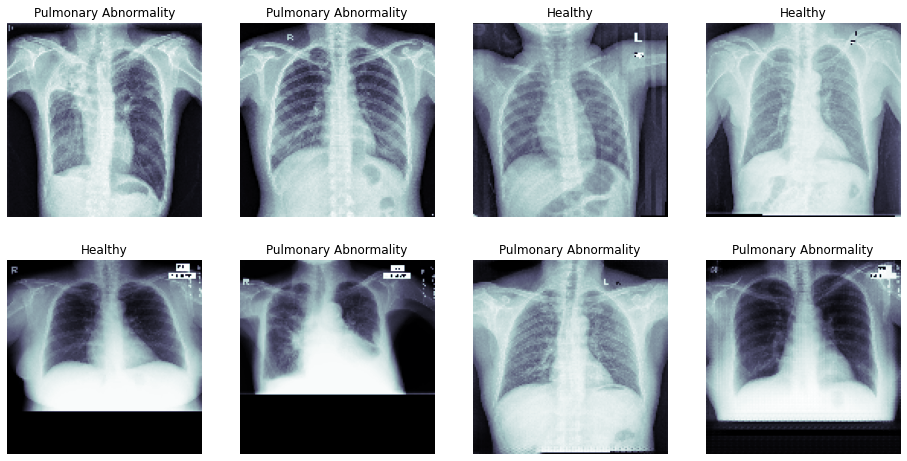

In [4]:
import matplotlib.pyplot as plt

label_to_name = (
    'Healthy',
    'Pulmonary Abnormality'
)

images, labels = next(train_generator)
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, l, a in zip(images, labels, ax.flatten()):
    a.imshow(denormalize(i[:, :, 0]), cmap='bone')
    a.set_title(label_to_name[np.argmax(l)])
    a.axis('off')

Model is based on https://github.com/zeeshannisar/Transfer-Learning-and-Fine-Tuning-with-Pre-Trained-Networks/blob/master/Transfer%20Learning%20with%20VGG16/Fine%20tuning%20with%20Pretrained%20VGG16%20for%20Tuberculosis%20Classification.ipynb

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

CLASS_COUNT = 2 # normal and abnormal

In [6]:
def get_model(optimizer, learning_rate, dropout_rate, units):
    img_shape = (IMG_SIZE, IMG_SIZE, 3)
    vgg16_model = VGG16(input_shape=img_shape,
                        include_top=False, weights='imagenet')
    vgg16_model.trainable = False

    inputs = Input(img_shape)
    outputs = vgg16_model(inputs)
    outputs = BatchNormalization(name='BatchNormalization')(outputs)
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(units)(outputs)
    outputs = LeakyReLU(alpha=0.1)(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = Dense(CLASS_COUNT, activation='sigmoid')(outputs)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(
        optimizer(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
        ]
    )

    model.summary()
    return model

In [7]:
TRAIN_COUNT = train_generator.samples
VALIDATION_COUNT = validation_generator.samples
TUNE_EPOCHS = 100

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/{idx}/100',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    stop_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience=15)
    board_callback = TensorBoard(log_dir=f'logs/cyclegan3')
    
    return checkpoint_callback, stop_callback, board_callback

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def get_callbacks(idx):
    checkpoint_callback = ModelCheckpoint(
        f'checkpoint/cyclegan3',
        monitor='val_accuracy',
        verbose=1,
        mode='max',
        save_best_only=True
    )
    board_callback = TensorBoard(log_dir=f'logs/cyclegan3')
    
    return checkpoint_callback, board_callback

In [10]:
TRAIN_COUNT = train_generator.samples

In [11]:
model = get_model(tf.keras.optimizers.Adam, 3e-4, 0.3, 256)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
BatchNormalization (BatchNor (None, 4, 4, 512)         2048      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0     

In [12]:
model = tf.keras.models.load_model('checkpoint/cyclegan3')

In [13]:
model.fit(
    train_generator,
    steps_per_epoch=ceil(TRAIN_COUNT/BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=ceil(VALIDATION_COUNT/BATCH_SIZE),
    epochs=TUNE_EPOCHS,
    callbacks=get_callbacks(i),
    initial_epoch=40
)

Epoch 41/100
63/63 [==============================] - 12s 136ms/step - loss: 0.4913 - accuracy: 0.7425 - false_positives: 255.0000 - false_negatives: 272.0000 - val_loss: 0.3203 - val_accuracy: 0.9114 - val_false_positives: 7.0000 - val_false_negatives: 8.0000

Epoch 00041: val_accuracy improved from -inf to 0.91139, saving model to checkpoint/cyclegan3
INFO:tensorflow:Assets written to: checkpoint/cyclegan3/assets
Epoch 42/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4889 - accuracy: 0.7435 - false_positives: 251.0000 - false_negatives: 267.0000 - val_loss: 0.3227 - val_accuracy: 0.9114 - val_false_positives: 7.0000 - val_false_negatives: 7.0000

Epoch 00042: val_accuracy did not improve from 0.91139
Epoch 43/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4833 - accuracy: 0.7555 - false_positives: 242.0000 - false_negatives: 246.0000 - val_loss: 0.3157 - val_accuracy: 0.9114 - val_false_positives: 7.0000 - val_false_negatives: 8.0000

Epoch 


Epoch 00066: val_accuracy did not improve from 0.91139
Epoch 67/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4418 - accuracy: 0.7555 - false_positives: 246.0000 - false_negatives: 240.0000 - val_loss: 0.3039 - val_accuracy: 0.8987 - val_false_positives: 8.0000 - val_false_negatives: 8.0000

Epoch 00067: val_accuracy did not improve from 0.91139
Epoch 68/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4462 - accuracy: 0.7635 - false_positives: 239.0000 - false_negatives: 243.0000 - val_loss: 0.3068 - val_accuracy: 0.8987 - val_false_positives: 9.0000 - val_false_negatives: 9.0000

Epoch 00068: val_accuracy did not improve from 0.91139
Epoch 69/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4460 - accuracy: 0.7515 - false_positives: 245.0000 - false_negatives: 253.0000 - val_loss: 0.3086 - val_accuracy: 0.8987 - val_false_positives: 8.0000 - val_false_negatives: 8.0000

Epoch 00069: val_accuracy did not improve from 0.91139


Epoch 00092: val_accuracy did not improve from 0.91139
Epoch 93/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4109 - accuracy: 0.7844 - false_positives: 220.0000 - false_negatives: 222.0000 - val_loss: 0.3246 - val_accuracy: 0.8734 - val_false_positives: 10.0000 - val_false_negatives: 10.0000

Epoch 00093: val_accuracy did not improve from 0.91139
Epoch 94/100
63/63 [==============================] - 4s 58ms/step - loss: 0.3895 - accuracy: 0.7764 - false_positives: 217.0000 - false_negatives: 216.0000 - val_loss: 0.3267 - val_accuracy: 0.8734 - val_false_positives: 10.0000 - val_false_negatives: 10.0000

Epoch 00094: val_accuracy did not improve from 0.91139
Epoch 95/100
63/63 [==============================] - 4s 58ms/step - loss: 0.4203 - accuracy: 0.7585 - false_positives: 240.0000 - false_negatives: 231.0000 - val_loss: 0.3409 - val_accuracy: 0.8481 - val_false_positives: 12.0000 - val_false_negatives: 13.0000

Epoch 00095: val_accuracy did not improve from 0

In [14]:
%load_ext tensorboard
%tensorboard --logdir logs/cyclegan3

## Test model augmented with FastGAN

In [15]:
test_dir = '../xrays_256/test'

In [16]:
test_generator = image_generator.flow_from_directory(
    directory=test_dir,
    **flow_args
)

Found 79 images belonging to 2 classes.


In [17]:
TEST_COUNT = test_generator.samples

In [21]:
print('Evaluate model with best hyperparameters on test data:')
# for hp, v in zip((k for k in HYPERPARAMETERS), (tf.keras.optimizers.Adam, 3e-4, 0.3, 256)):
#     print(f'{hp}: {v}')

model = tf.keras.models.load_model(f'checkpoint/cyclegan3')
metrics = model.evaluate(
    test_generator,
    steps=ceil(TEST_COUNT/BATCH_SIZE),
    return_dict=True
)

accuracy = metrics['accuracy']
false_positives = metrics[f'false_positives']
false_negatives = metrics[f'false_negatives']

print(f'Accuracy on test data: {accuracy:.2f}')
print(f'False positives: {false_positives:.2f}')
print(f'False negatives: {false_negatives:.2f}')

Evaluate model with best hyperparameters on test data:
5/5 [==============================] - 1s 52ms/step - loss: 0.4751 - accuracy: 0.7975 - false_positives: 15.0000 - false_negatives: 15.0000
Accuracy on test data: 0.80
False positives: 15.00
False negatives: 15.00
